In [1]:
#import libraries and the functions we defined
import os
import numpy as np
import keras
import tensorflow
from sklearn.model_selection import train_test_split
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt
from Networks.metrics import dice_coef, jaccard_distance
from Networks import models
from sklearn.model_selection import train_test_split
from Networks.switchnorm import SwitchNormalization
from Networks.groupnorm import GroupNormalization
from Networks.instnorm import InstanceNormalization
import fnmatch
from Data_Gen_2D import DataGenerator

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
from tensorflow.python.client import device_lib
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
#get the dataset path, input and masks
def get_file_and_path(data_path, phrase):
    set_of = [os.path.join(data_path, f) for f in os.listdir(data_path) if phrase in f]
    return set_of

In [4]:
#define the input image and mask locations
data_path_1 = r"D:\Data_128\data\\"
#data_path_2 = r"D:\Data_128\npy\\"
#use the function to collect all input images
images_1 = get_file_and_path(data_path_1, '_M')
#images_2 = get_file_and_path(data_path_2, '_M')
images = images_1 
print(len(images))
#similarly gather all the masks
labels_1 = get_file_and_path(data_path_1, '_K')
#labels_2 = get_file_and_path(data_path_2, '_K')
labels = labels_1 
print(len(labels))


79307
79307


D:\Data_128\data\\492327_3_140_L_91_K.npy


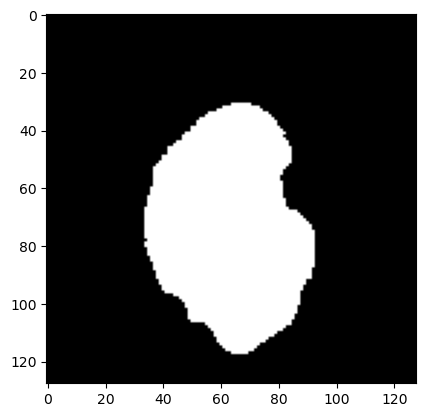

In [5]:
%matplotlib inline
print(labels[-150])
image = np.load(labels[-150])
plt.imshow(image, cmap='gray')

In [6]:
#map the masks to the corresponding input images
labels = {image: i for i, image in enumerate(images)}
print(len(labels))

79307


In [7]:
#backup
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

## Use the below code if you want the program to split the training, validation and test images

In [8]:
# getting the patient id list
id_list = [os.path.basename(image)[:11] for image in images]
unique_ids = list(set(id_list))
print(len(unique_ids))
# Splitting data into train and validation sets
train_ids, val_ids = train_test_split(unique_ids, train_size=0.8)

train_list = [image for image in images if any(phrase in image for phrase in train_ids)]
val_list = [image for image in images if any(phrase in image for phrase in val_ids)]
partition = {'train': train_list, 'validation': val_list}
print(len(train_ids))
print(len(val_ids))
print(len(train_list))
print(len(val_list))

360
288
72
63510
15797


## Use the below code if you have an excel file with the train, test and val ids
Make sure you have three columns in the excel file for training, validation and testing

In [9]:
labels = {image: i for i, image in enumerate(images)}
print(len(labels))
id_list = [os.path.basename(image)[:17] for image in images]
unique_ids = list(set(id_list))

79307


In [10]:
import pandas as pd

df = pd.read_excel(r"C:\Users\UAB\Segmentation - Main1_CK\Human Model\Keras\Data for AI development.xlsx", engine='openpyxl')
df = df.iloc[1:, 0:4]
df.columns = df.iloc[0]

train_csv_list = df.filter(regex='Training').iloc[:, 0].dropna().values.tolist()[1:]
val_csv_list = df.filter(regex='Validation').iloc[:, 0].dropna().values.tolist()[1:]

train_sets = [name for name in unique_ids for phrase in train_csv_list if phrase[:-2] in name and phrase[-1] in name]
val_sets = [name for name in unique_ids for phrase in val_csv_list if phrase[:-2] in name and phrase[-1] in name]

train_list = [image for image in images if any(phrase in image for phrase in train_sets)]
val_list = [image for image in images if any(phrase in image for phrase in val_sets)]


In [11]:
print(len(train_csv_list))
print(train_csv_list[0])
print(len(val_csv_list))
print(val_csv_list[0])

171
439240L
19
457036L


In [12]:
print(len(train_list))
print(len(val_list))
train_list1 = train_list+train_list
val_list1 = val_list+val_list
partition = {'train':train_list1, 'validation':val_list1}

70712
9042


# Set up Training Environment 

In [13]:
params = {'dim': (128,128),
          'batch_size': 32,
          'n_classes': 2,
          'n_channels': 1,
          'shuffle': True}
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)
X,y = training_generator[8]
print(X.shape, y.shape)

(32, 128, 128, 1) (32, 128, 128, 2)


## Visualize if images are correctly mapped with their masks

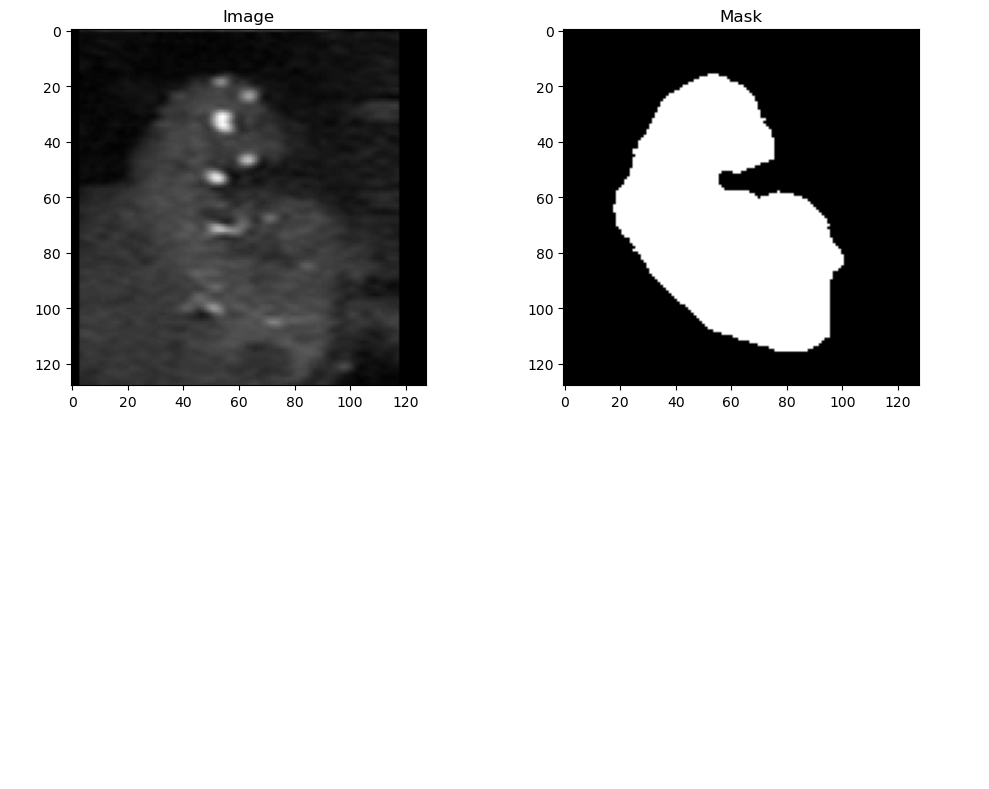

In [14]:
n = 10
X_batch = X[n,:,:,:]
X_img = X_batch[:,:,0]

y_batch = y[n,:,:,:]
y_img_1 = y_batch[:,:,1]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].imshow(X_img, cmap='gray')
axs[0, 0].set_title('Image')

axs[0, 1].imshow(y_img_1, cmap='gray')
axs[0, 1].set_title('Mask')

axs[1, 0].axis('off')  # Hide the empty subplot
axs[1, 1].axis('off')  # Hide the empty subplot

plt.tight_layout()
plt.show()

In [1]:
model = models.runetppp_2d((128, 128, 1), n_class=2, apply_batch_norm=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 runetppp_down0_0 (Conv2D)      (None, 128, 128, 64  576         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 runetppp_down0_0_bn (BatchNorm  (None, 128, 128, 64  256        ['runetppp_down0_0[0][0]']       
 alization)                     )                                                             

 hNormalization)                                                                                  
                                                                                                  
 runetppp_down3_conv_0_activati  (None, 16, 16, 512)  0          ['runetppp_down3_conv_0_bn[0][0]'
 on (ReLU)                                                       ]                                
                                                                                                  
 runetppp_down3_conv_1 (Conv2D)  (None, 16, 16, 512)  2359296    ['runetppp_down3_conv_0_activatio
                                                                 n[0][0]']                        
                                                                                                  
 runetppp_down3_conv_1_bn (Batc  (None, 16, 16, 512)  2048       ['runetppp_down3_conv_1[0][0]']  
 hNormalization)                                                                                  
          

                                                                                                  
 runetppp_up_1_en1_activation (  (None, 64, 64, 64)  0           ['runetppp_up_1_en1_bn[0][0]']   
 ReLU)                                                                                            
                                                                                                  
 runetppp_down_from1_to0_0 (Con  (None, 64, 64, 64)  36864       ['runetppp_up_1_en0_activation[0]
 v2D)                                                            [0]']                            
                                                                                                  
 runetppp_down_from1_to1_0 (Con  (None, 64, 64, 64)  36864       ['runetppp_up_1_en1_activation[0]
 v2D)                                                            [0]']                            
                                                                                                  
 runetppp_

 runetppp_down_from2_to0_0_bn (  (None, 128, 128, 64  256        ['runetppp_down_from2_to0_0[0][0]
 BatchNormalization)            )                                ']                               
                                                                                                  
 runetppp_down_from2_to1_0_bn (  (None, 128, 128, 64  256        ['runetppp_down_from2_to1_0[0][0]
 BatchNormalization)            )                                ']                               
                                                                                                  
 runetppp_down_from2_to2_0_bn (  (None, 128, 128, 64  256        ['runetppp_down_from2_to2_0[0][0]
 BatchNormalization)            )                                ']                               
                                                                                                  
 runetppp_down_from2_to0_0_acti  (None, 128, 128, 64  0          ['runetppp_down_from2_to0_0_bn[0]
 vation (R

In [16]:
# for switch normalization
from keras.layers import Input,Concatenate
from keras.models import Model
input_shape = (128, 128, 1)
num_classes = 2

# Create an input layer
inputs = Input(shape=input_shape)

# Duplicate the single channel input to have 3 channels (not for inst)
#inputs_3_channels = Concatenate()([inputs, inputs, inputs])

# Apply switchable normalization to the input
#normalized_inputs = SwitchNormalization()(inputs_3_channels)

# Apply group normalization to the input
#normalized_inputs = GroupNormalization(groups=3)(inputs_3_channels)

# Apply instance normalization to the input
normalized_inputs = InstanceNormalization()(inputs)

# Build the UNet3+ model with switchable normalization
#model = unet_plus.unet_model_3plus(input_shape, num_classes, base_filter=64, activation='relu', final_activation='softmax', normalization=None)
outputs = model(normalized_inputs)  # Pass the normalized input through the UNet3+ model

# Create the final model
model = Model(inputs, outputs)

In [3]:
from Networks import models
from keras.layers import Input
from keras.models import Model
base_channel = 32
input_size = (None,None,1)
inputs = Input(input_size)
model = models.unetppp_2d(inputs)
full_model = Model(inputs, model)
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d_36 (Conv2D)             (None, None, None,   320         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 conv2d_37 (Conv2D)             (None, None, None,   9248        ['conv2d_36[0][0]']              
                                32)                                                           

                                                                  'conv2d_48[0][0]',              
                                                                  'conv2d_49[0][0]',              
                                                                  'conv2d_50[0][0]']              
                                                                                                  
 conv2d_51 (Conv2D)             (None, None, None,   461120      ['concatenate_4[0][0]']          
                                320)                                                              
                                                                                                  
 batch_normalization_4 (BatchNo  (None, None, None,   1280       ['conv2d_51[0][0]']              
 rmalization)                   320)                                                              
                                                                                                  
 re_lu_4 (

                                160)                              'conv2d_59[0][0]',              
                                                                  'conv2d_60[0][0]',              
                                                                  'conv2d_61[0][0]',              
                                                                  'conv2d_62[0][0]']              
                                                                                                  
 conv2d_63 (Conv2D)             (None, None, None,   461120      ['concatenate_6[0][0]']          
                                320)                                                              
                                                                                                  
 batch_normalization_6 (BatchNo  (None, None, None,   1280       ['conv2d_63[0][0]']              
 rmalization)                   320)                                                              
          

In [17]:
# define the checkpoint
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard

# Define the patience values for each monitored quantity
patience_loss = 6
patience_val_loss = 6

# Set the file path for saving the best model based on training loss
filepath_loss = "csc_kid_up_in_train.h5"

# Set the file path for saving the best model based on validation loss
filepath_val_loss = "csc_kid_up_in_val.h5"

# Define the ModelCheckpoint callbacks for each monitored quantity
checkpoint_loss = ModelCheckpoint(filepath_loss, monitor='loss', verbose=1, save_best_only=True, mode='min')
checkpoint_val_loss = ModelCheckpoint(filepath_val_loss, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Define the EarlyStopping callbacks for each monitored quantity
early_stopping_loss = EarlyStopping(monitor='loss', patience=patience_loss)
early_stopping_val_loss = EarlyStopping(monitor='val_loss', patience=patience_val_loss)

# Create a list of callbacks for each monitored quantity
callbacks_list_loss = [checkpoint_loss, early_stopping_loss]
callbacks_list_val_loss = [checkpoint_val_loss, early_stopping_val_loss]

# Create a TimingCallback to measure the training time
#cb = TimingCallback()
callbacks_list = callbacks_list_loss+callbacks_list_val_loss

In [18]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
  loss=jaccard_distance,
  metrics=[dice_coef])

In [19]:
# Train model on dataset
history = model.fit(training_generator, epochs = 200,
                    validation_data = validation_generator,
                    use_multiprocessing=False,
                    workers=6, batch_size = 32,callbacks=[callbacks_list])

Epoch 1/200
4419/4419 [==============================] - ETA: 0s - loss: 0.0549 - dice_coef: 0.9721
Epoch 1: loss improved from inf to 0.05486, saving model to csc_kid_up_in_train.h5

Epoch 1: val_loss improved from inf to 0.07716, saving model to csc_kid_up_in_val.h5
4419/4419 [==============================] - 1043s 234ms/step - loss: 0.0549 - dice_coef: 0.9721 - val_loss: 0.0772 - val_dice_coef: 0.9607
Epoch 2/200
4419/4419 [==============================] - ETA: 0s - loss: 0.0376 - dice_coef: 0.9808
Epoch 2: loss improved from 0.05486 to 0.03759, saving model to csc_kid_up_in_train.h5

Epoch 2: val_loss improved from 0.07716 to 0.06548, saving model to csc_kid_up_in_val.h5
4419/4419 [==============================] - 832s 188ms/step - loss: 0.0376 - dice_coef: 0.9808 - val_loss: 0.0655 - val_dice_coef: 0.9666
Epoch 3/200
4419/4419 [==============================] - ETA: 0s - loss: 0.0350 - dice_coef: 0.9822
Epoch 3: loss improved from 0.03759 to 0.03497, saving model to csc_kid_up_

In [22]:
#epoch_times = history.history['epoch_times']
val_losses = history.history['val_loss']
train_losses = history.history['loss']
val_dice = history.history['val_dice_coef']  # Replace with the actual key for validation dice score
train_dice = history.history['dice_coef']  # Replace with the actual key for training dice score

In [23]:
import pandas as pd
data = pd.DataFrame({
    'Epoch': range(1, len(val_losses) + 1),
    'Val Loss': val_losses,
    'Train Loss': train_losses,
    'Val Dice': val_dice,
    'Train Dice': train_dice
})

# Export the DataFrame to an Excel file
data.to_excel(r"D:\Results_CK\unet++var\gn_only\cys\train.xlsx", index=False)

# Prediction 

In [7]:
#get the images
def gather_images(data_path):
    images = [f for f in os.listdir(data_path) if '_M' in f]
    return images

In [4]:
#define custom objects
def Hausdorff_distance(y_true, y_pred, smooth=100):
        intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
        sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
        jac = (intersection + smooth) / (sum_ - intersection + smooth)
        return (1 - jac) * smooth

def dice_coef(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
                K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(self, y_true, y_pred):
    loss = 1 - self._dice_coef(y_true, y_pred)
    return loss

class GELU(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(GELU, self).__init__(**kwargs)

    def call(self, inputs):
        return 0.5 * inputs * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (inputs + 0.044715 * tf.pow(inputs, 3))))

In [8]:
#load weights
model = keras.models.load_model(r"C:\Users\UAB\Downloads\csc_kid_up_in_val.h5", custom_objects={
                       'jaccard_distance': Hausdorff_distance,
                       'dice_coef_loss': dice_coef_loss,
                       'dice_coef': dice_coef, 'InstanceNormalization':InstanceNormalization, 'GELU': GELU}) #load the weights

model_name = 'test'  #give a name of your choice
data_path = r"D:\Data_128\data\\"  #set the path to masks and imgaes
images = gather_images(data_path) #get the input images using the defined functions
print(len(images))  #check if the images are gathered correctly
print(images[2000])
print(images[0:2])

79307
110080_2_87_L_82_M.npy
['101934_0_96_L_0_M.npy', '101934_0_96_L_10_M.npy']


In [9]:
image_list = []
phrase_list1 = ['283935R','290336L','290336R','295106L','295106R']
phrase_list2 = ['380166R','383193L','383193R','385151L','385151R']
phrase_list3 = ['457036L','457036R']
phrase_list4 = ['113994L','139486R','157925R','183417R','186714L','186714R','187456L']
phrase_list = phrase_list3+phrase_list2+phrase_list1+phrase_list4
for phrase in phrase_list3: #gather all the images corresponding to test phrases
    image_list.extend([name for name in images if phrase[:-2] in name and phrase[-1] in name])

label_mapping = {name: index for index, name in enumerate(images)} #map the labels for prediction
labels = {name: label_mapping[name] for name in image_list}

In [11]:
#the below code does the prediction by passing the test images 
import numpy
import nibabel


label_list = []
predictions = []
pred_path1 = r"D:\npy"
pred_path2 = r"D:\t"
pred_path3 = r"D:\Results_CK\unet++var\in\kid\nii"
# Check if the directory exists
if not os.path.exists(pred_path1):
    # Create the directory
    os.makedirs(pred_path1)
    print(f"Directory '{pred_path1}' created.")
else:
    print(f"Directory '{pred_path1}' already exists.")
if not os.path.exists(pred_path2):
    # Create the directory
    os.makedirs(pred_path2)
    print(f"Directory '{pred_path2}' created.")
else:
    print(f"Directory '{pred_path2}' already exists.")
if not os.path.exists(pred_path3):
    # Create the directory
    os.makedirs(pred_path3)
    print(f"Directory '{pred_path3}' created.")
else:
    print(f"Directory '{pred_path3}' already exists.")
#pred_path2 = r"D:\NII" #optional - if u want to convert npy to nii
images = image_list

for i, image in enumerate(images):
    image_stack = np.empty((1, 128, 128, 1))  # create a tensor to hold images
    image = np.load(os.path.join(data_path, image))
    image_stack[0, ..., 0] = image  #assign the image as a part of stack
    label_match = str(images[i][:-5] + 'C.npy') #match label
    label_list.append(label_match)

    img_prediction = model.predict(image_stack)  #model prediction

    for z, img_pred in enumerate(img_prediction): #saving the prediction as nii or npy
        img_numb = z + i
        image_save = img_pred[:, :]  #removing extra axis from the predicted image
        label = label_list[img_numb][:-5]
        filename = f"{label}{model_name}_P.npy"
        filename1 = f"{label}{model_name}_P.nii"
        np.save(os.path.join(pred_path1, filename), image_save)
        #the below code is optional if the above npy have to be saved as nii
        #image = np.load(os.path.join(pred_path1, filename))
        #affine = numpy.eye(4)
        #nifti_file = nibabel.Nifti1Image(image_save, affine)
        #nib.save(nifti_file, os.path.join(pred_path2, filename1))

Directory 'D:\npy' already exists.
Directory 'D:\t' already exists.
Directory 'D:\Results_CK\unet++var\in\kid\nii' already exists.


In [12]:
import numpy as np
from keras import backend as K
smooth = 1

def jaccard_distance_loss(y_true, y_pred, smooth=100): 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(K.abs(y_true_f * y_pred_f)) 
    sum_ = K.sum(K.abs(y_true_f) + K.abs(y_pred_f)) 
    jac = (intersection + smooth) / (sum_ - intersection + smooth) 
    return (jac) * smooth 

def mean_length_error(y_true, y_pred):
    y_true_f = K.sum(K.round(K.flatten(y_true)))
    y_pred_f = K.sum(K.round(K.flatten(y_pred)))
    delta = (y_pred_f - y_true_f)
    return K.mean(K.tanh(delta))

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def np_dice_coef(y_true, y_pred):
    tr = y_true.flatten()
    pr = y_pred.flatten()
    return (2. * np.sum(tr * pr) + smooth) / (np.sum(tr) + np.sum(pr) + smooth)

def sensitivity(y_true, y_pred):
    true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + keras.backend.epsilon())

def specificity(y_true, y_pred):
    true_negatives = keras.backend.sum(keras.backend.round(keras.backend.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = keras.backend.sum(keras.backend.round(keras.backend.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + keras.backend.epsilon())

def roc(y_true, y_pred):
    true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true, 0, 1)))
    return 1 - (true_positives / (possible_positives + keras.backend.epsilon()))

def IOU(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    return np.sum(intersection) / np.sum(union)

def HD(y_true, y_pred):
    sum_sq = np.sum(np.square(y_true - y_pred))
    return np.sqrt(sum_sq)


def HD1(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    msd = K.mean(K.square(y_true_f - y_pred_f))
    return msd

In [13]:
def gather_set(data_path, phrase):
    set_of = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if phrase in f:
        set_of.append(f)
      else:
        continue
    set_of = np.array(set_of)

    indices = np.array(range(len(set_of))) # we will use this in the next step.

    return set_of


In [14]:
#filepath_predictions = r'D:\Results_CK\Compression\Numpy\PCA\Kidneys\npy'
filepath_predictions = r"D:\npy"
filepath_tensors = r"D:\t"
filepath_data = r"D:\Data_128\data\\"

images = gather_set(filepath_predictions, 'P')
model_name = 'test'

In [15]:
id_list = []   
for i in range(len(images)):
    image_name = images[i]
    unique_id =  image_name[0:14]
    id_list.append(unique_id)
unique_ids = list(set(id_list))
for i in range(len(unique_ids)):
    name = unique_ids[i] 
    if not name.endswith('_'):
        name = name+'_'
        unique_ids[i]=name

In [16]:
import re
for i in range(len(unique_ids)):
    pt_info = unique_ids[i]
    pt_num, yr_num, num_slices = re.findall(r'\d+', pt_info)
    tensor = np.zeros((128,128,int(num_slices)))
    for x in range(int(num_slices)):
        img_name = unique_ids[i]+str(x)+'_K.npy'
        image = np.load(filepath_data + '\\' + img_name)
        img_slice = image
        tensor[:,:,x] = img_slice
        x = x+1
    new_fname = unique_ids[i]+'K.npy'
    np.save(os.path.join(filepath_tensors, new_fname), tensor)
    
for i in range(len(unique_ids)):
    pt_info = unique_ids[i]
    pt_num, yr_num, num_slices = re.findall(r'\d+', pt_info)
    tensor = np.zeros((128,128,int(num_slices)))
    for x in range(int(num_slices)):
        img_name = unique_ids[i]+str(x)+ '_' + model_name +'_P.npy'
        image = np.load(filepath_predictions + '\\' + img_name)
        img_slice = image[:,:,1]
        tensor[:,:,x] = img_slice
        x = x+1
    new_fname = unique_ids[i]+ model_name +'_Prediction.npy'
    np.save(os.path.join(filepath_tensors, new_fname), tensor)

In [17]:
filepath_tensors = filepath_tensors
pred_list = gather_set(filepath_tensors, '_Prediction')
true_list = gather_set(filepath_tensors, '_K.')

In [18]:
results1 = []
results = []
for i in range(len(pred_list)):
    prediction = np.load(filepath_tensors + '\\'+ pred_list[i])
    true = np.load(filepath_tensors + '\\'+true_list[i])
    hd_dist = (HD(true, prediction)/100)
    hd_dist1 = HD1(true, prediction)
    #mean_error = mean_length_error(true, prediction)
    jac=(jaccard_distance_loss(true, prediction)/100)
    #dist = dist/10
    dice_calc = dice_coef(true,prediction)
    #sen = sensitivity(true, prediction)
    #spec = specificity(true, prediction)
    #rocs = roc(true, prediction)
    #accuracy_score(true, prediction, normalize=True, sample_weight=None)
    #true = true>0.5
    
    #prediction = prediction > 0.5   
    
 
    #auc = metrics.roc_auc_score(true, prediction)
    iou_dist = IOU(true,prediction)
    #jac1 = jaccard_score(true, prediction,average='binary')
    
    if dice_calc>0.68:
        #model = pred_list[i][18:46]
        patient = pred_list[i][:17]
        new_calc = [dice_calc.numpy(), hd_dist, hd_dist1.numpy, jac.numpy(), iou_dist]
        new_calc1 = [patient, dice_calc.numpy(), hd_dist, hd_dist1.numpy, jac.numpy(), iou_dist]
        #new_calc = [dice_calc.numpy()]
        results.append(new_calc)
        results1.append(new_calc1)

In [19]:
min_values = []
for col in zip(*results):
    col_values = [float(val()) if callable(val) else float(val) for val in col]
    col_min = min(col_values)
    min_values.append(col_min)

# patient_min = min_values[0]  # Minimum value of patient values
dice_calc_min = min_values[0]  # Minimum value of dice_calc values
print(dice_calc_min)

for i in results1:
    if min_values[0] in i:
        print(i)

min_values = []
for col in zip(*results):
    col_values = [float(val()) if callable(val) else float(val) for val in col]
    col_min = max(col_values)
    min_values.append(col_min)

# patient_min = min_values[0]  # Minimum value of patient values
dice_calc_min = min_values[0]  # Minimum value of dice_calc values
print(dice_calc_min)

for i in results1:
    if min_values[0] in i:
        print(i)

0.8420158775506565
['457036_1_105_L_te', 0.8420158775506565, 2.890796672077761, <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float64, numpy=0.048576459026784896>>, 0.727225254878882, 0.17088681175595238]
0.9438279759329913
['457036_3_111_R_te', 0.9438279759329913, 1.6253005544585577, <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float64, numpy=0.014525277860202525>>, 0.8936711914936278, 0.13629590283643017]


In [20]:
averages = []
for col in zip(*results):
    col_values = [float(val()) if callable(val) else float(val) for val in col]
    col_avg = sum(col_values) / len(col_values)
    averages.append(col_avg)

#patient_avg = averages[0]  # Average of patient values
dice_calc_avg = averages[0]  # Average of dice_calc values
hd_dist_avg = averages[1]  # Average of hd_dist values
hd_dist1_avg = averages[2]  # Average of hd_dist1 values
jac_avg = averages[3]  # Average of jac values
iou_dist_avg = averages[4]  # Average of iou_dist values
print("Dice Coefficient Average:", dice_calc_avg)
print("HD Distance Average:", hd_dist_avg)
print("HD1 Distance Average:", hd_dist1_avg)
print("Jaccard Distance Average:", jac_avg)
print("IOU Distance Average:", iou_dist_avg)

Dice Coefficient Average: 0.8974605453403786
HD Distance Average: 2.2557731120159104
HD1 Distance Average: 0.031109551249895107
Jaccard Distance Average: 0.8160556349815984
IOU Distance Average: 0.15251781605999135


In [34]:
import math

# Calculate standard deviation for each parameter
dice_calc_sd = math.sqrt(sum((float(val()) if callable(val) else float(val) - dice_calc_avg) ** 2 for val in results[0]) / len(results[0]))
hd_dist_sd = math.sqrt(sum((float(val()) if callable(val) else float(val) - hd_dist_avg) ** 2 for val in results[1]) / len(results[1]))
hd_dist1_sd = math.sqrt(sum((float(val()) if callable(val) else float(val) - hd_dist1_avg) ** 2 for val in results[2]) / len(results[2]))
jac_sd = math.sqrt(sum((float(val()) if callable(val) else float(val) - jac_avg) ** 2 for val in results[3]) / len(results[3]))
iou_dist_sd = math.sqrt(sum((float(val()) if callable(val) else float(val) - iou_dist_avg) ** 2 for val in results[4]) / len(results[4]))

# Print standard deviation values
print("Dice Coefficient Standard Deviation:", dice_calc_sd)
print("HD Distance Standard Deviation:", hd_dist_sd)
print("HD1 Distance Standard Deviation:", hd_dist1_sd)
print("Jaccard Distance Standard Deviation:", jac_sd)
print("IOU Distance Standard Deviation:", iou_dist_sd)

Dice Coefficient Standard Deviation: 0.3618699014701029
HD Distance Standard Deviation: 0.840657460632272
HD1 Distance Standard Deviation: 0.938614203495385
Jaccard Distance Standard Deviation: 0.4542534629573794
IOU Distance Standard Deviation: 0.9258641438623455


In [36]:
def gather_images(data_path):
    images = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if '_test' in f:
        images.append(f)
        
      else:
        continue
    images = np.array(images)
    #segmentations = np.array(segmentations)

    indices = np.array(range(len(images))) # we will use this in the next step.

    return images

In [37]:
filepath_tensors = r"D:\Results_CK\unet++var\in\kid\t"
images = gather_images(filepath_tensors)
print(len(images))
path = r"D:\Results_CK\unet++var\in\kid\nii"
for i in range(len(images)):
    image = np.load(os.path.join(filepath_tensors, images[i]))
    affine = np.eye(4)
    nifti_file = nib.Nifti1Image(image, affine)
    filename = images[i][:-3]+'nii'
    nib.save(nifti_file, os.path.join(path, filename))

76
